In [36]:
import json
import numpy as np
import matplotlib.pyplot as plt
import copy
%matplotlib inline
import mpld3
mpld3.enable_notebook()

In [37]:
filename = 'reko_StartCelebrityRecognition_099b2c11-6cd0-4769-b83c-7999b86ff6a0.json'
with open(filename, 'r') as f:
    dico_cel = json.load(f)

filename = 'reko_StartFaceDetection_bddf07c5-32c7-4f5c-9d0e-27e4df1cb6e2.json'
with open(filename, 'r') as f:
    dico_face = json.load(f)

In [38]:
#Compute the surface of the intersection of 2 bounding boxes
def getIntersectionRatio(a, b, epsilon=1e-5):
    """ Given two boxes `a` and `b` defined as a list of four numbers:
            [x1,y1,x2,y2]
        where:
            x1,y1 represent the upper left corner
            x2,y2 represent the lower right corner
        It returns the Intersect of Union score for these two boxes.

    Args:
        a:          (list of 4 numbers) [x1,y1,x2,y2]
        b:          (list of 4 numbers) [x1,y1,x2,y2]
        epsilon:    (float) Small value to prevent division by zero

    Returns:
        (float) The Intersect of Union score.
    """
    # COORDINATES OF THE INTERSECTION BOX
    x1 = max(a[0], b[0])
    y1 = max(a[1], b[1])
    x2 = min(a[2], b[2])
    y2 = min(a[3], b[3])

    # AREA OF OVERLAP - Area where the boxes intersect
    width = (x2 - x1)
    height = (y2 - y1)
    # handle case where there is NO overlap
    if (width<0) or (height <0):
        return 0.0
    area_overlap = width * height

    # COMBINED AREA
    area_a = (a[2] - a[0]) * (a[3] - a[1])
    area_b = (b[2] - b[0]) * (b[3] - b[1])
    area_combined = min(area_a,area_b)

    # RATIO OF AREA OF OVERLAP OVER COMBINED AREA
    iou = abs(area_overlap / (area_combined+epsilon))
    return iou

In [4]:
# Flatten the files to list of dict
def flattenFiles(dico_cel,dico_face):
    # reshape the data : create a list of dictionnaries for faces 
    faces_list = []
    tp_face_array = np.array([])
    for idx in range(len(dico_face)):
        for idx_f, face in enumerate(dico_face[idx]['Faces']):
            tp = face['Timestamp']
            #print(tp)
            #a =input('khn')
            face_tp = copy.copy(face['Face'])
            #face_tp.pop('Landmarks')
            face_tp.pop('Pose')
            face_tp.pop('Quality')
            face_dic = {'Timestamp' : face['Timestamp'], 'Face' : face_tp }
            faces_list.append(face_dic)
            tp_face_array = np.append(tp_face_array, tp)

    # reshape the data : create a list of dictionnaries for celebrities
    tp_cel_array = []
    celebrities_list = []
    for idx in range(len(dico_cel)):
        for idx_c, celebrity in enumerate(dico_cel[idx]['Celebrities']):
            tp = celebrity['Timestamp']
            tp_cel_array = np.append(tp_cel_array, tp)
            celebrities_list.append(celebrity)
            
    return(celebrities_list,faces_list)

In [5]:
# get the left eye position from Landmarks
def getLeftEyePos(l_lm):
    X_cel , Y_cel = None, None
    for idx in range(len(l_lm)):
        if l_lm[idx]['Type'] == 'eyeLeft':
            X_cel , Y_cel = l_lm[idx]['X'] , l_lm[idx]['Y']
    return(X_cel , Y_cel)

In [6]:
# computes the score to merge celebrities_list and faces_list
def mergeFacesCelebrities(celebrities_list, faces_list, threshold):

    # numpy arrays
    face_idx = np.ones(len(celebrities_list))*-1
    face_score = np.ones(len(celebrities_list))*-1

    for idx_c, celebrity in enumerate(celebrities_list):

        bb_c = []
        X_cel = None
        Y_cel = None

        # bounding box celebrity face may not exist depending on time stamps
        if 'Face' in celebrity['Celebrity'].keys():
            bb_c = [celebrity['Celebrity']['Face']['BoundingBox']['Left'], celebrity['Celebrity']['Face']['BoundingBox']['Top'],
                    celebrity['Celebrity']['Face']['BoundingBox']['Left'] +
                    celebrity['Celebrity']['Face']['BoundingBox']['Width'],
                    celebrity['Celebrity']['Face']['BoundingBox']['Top'] + celebrity['Celebrity']['Face']['BoundingBox']['Height']]
            # eyeLeft celebrity
            X_cel, Y_cel = getLeftEyePos(celebrity['Celebrity']['Face']['Landmarks'])
        else:
            bb_c = [celebrity['Celebrity']['BoundingBox']['Left'], celebrity['Celebrity']['BoundingBox']['Top'],
                    celebrity['Celebrity']['BoundingBox']['Left'] +
                    celebrity['Celebrity']['BoundingBox']['Width'],
                    celebrity['Celebrity']['BoundingBox']['Top'] + celebrity['Celebrity']['BoundingBox']['Height']]

        # time stamp celebrity
        score_face_array = np.array([])
        idx_face_array = np.array([])
        score_eye_left_array = []
        dt_all = np.array([])

        for idx_f, face in enumerate(faces_list):

            # bounding box face
            bb_face = [face['Face']['BoundingBox']['Left'], face['Face']['BoundingBox']['Top'],
                       face['Face']['BoundingBox']['Left'] +
                       face['Face']['BoundingBox']['Width'],
                       face['Face']['BoundingBox']['Top'] + face['Face']['BoundingBox']['Height']]

            #compute the aera of the Face bounding box 
            bb_face_area = face['Face']['BoundingBox']['Width'] * face['Face']['BoundingBox']['Height']

            dt = celebrity['Timestamp'] - face['Timestamp']
            X_face, Y_face = getLeftEyePos(face['Face']['Landmarks'])

            # scores
            score_face = -1
            score_eye_left = 1
            if abs(dt) < 1000: # only find match if the boxes are within a 1s sphere

                if abs(dt) > 1 :
                    # can be celebrity face or celebrity bounding box (larger)
                    score_face = getIntersectionRatio(bb_face, bb_c, epsilon=1e-5)  # /abs(dt)
                else: # in case of exact match amplify the score 
                    score_face = getIntersectionRatio(bb_face, bb_c, epsilon=1e-5)*10
                
                # if the landmark are present for celebrity and face
                if None not in (X_cel, X_face, Y_cel, Y_face):
                    # compute a normalize distance between eye of celebrity and eye of face
                    # the normalization factor is the area of the bounding box of the face
                    score_eye_left = np.sqrt(
                        (X_cel - X_face)**2 + (Y_cel - Y_face)**2)/np.sqrt(bb_face_area)

                dt_all = np.append(dt_all, dt)

            # save the score for one face associated to one celebrity
            if score_face > 0:
                score_face_array = np.append(score_face_array, score_face)
                score_eye_left_array = np.append(
                    score_eye_left_array, score_eye_left)
                idx_face_array = np.append(idx_face_array, idx_f)

        # find the best face associated to each celecrity
        # if no face associated to celebrity within +/- 1 go to next time stamp 
        if score_face_array.size > 0:

            # for each celebrity get the closest face to get emotion
            # the score is in [0:100]
            # [0:10] for bounding box matching 
            # [0:10] for eyes matching 
            # so total score in [0:10]*[0:10]
            score_tot_array = score_face_array / (score_eye_left_array + 0.1)

            cel_det = np.argmax(score_tot_array)
            face_idx[idx_c] = idx_face_array[cel_det]
            face_score[idx_c] = score_tot_array[cel_det]

    #add the emotions and features from faces to celebrity 
    #merge the face and celebrity
    celebrities_faces_list = copy.copy(celebrities_list)
    for idx_c, celebrity in enumerate(celebrities_list):
        if face_score[idx_c] > threshold :
            celebrities_faces_list[idx_c]['FaceReko'] = faces_list[face_idx[idx_c].astype(int)]['Face']    
            celebrities_faces_list[idx_c]['FaceReko']['EmotionScore'] = face_score[idx_c]
        else:
            celebrities_faces_list[idx_c]['FaceReko'] = {}
            celebrities_faces_list[idx_c]['FaceReko']['EmotionScore'] = face_score[idx_c] 
            
    return(celebrities_faces_list)


In [7]:
def genScoreCelebrity(celebrities_faces_list,name_list,emotion_list) : 
    
    # Average score per celebrity
    name_score = dict()
    for name in name_list : 
        name_score[name] = dict()
        for emotion in emotion_list:
            name_score[name][emotion] = 0
        name_score[name]['cpter'] = 0

    for name in name_list:
        for cel_face in celebrities_faces_list:
            if name == cel_face['Celebrity']['Name']:
                if 'Emotions' in cel_face['FaceReko'].keys():
                    name_score[name]['cpter'] += 1
                    for emotion in cel_face['FaceReko']['Emotions']:
                        name_score[name][emotion['Type']] += emotion['Confidence']

    # Generate the output dico with normalized score 
    for name in name_list:
        cpter = name_score[name]['cpter']
        for emotion in name_score[name]:
            name_score[name][emotion] /= cpter
        name_score[name]['cpter'] = cpter

    return(name_score)

In [8]:
def plotPyCharCel(name_score,name_list,emotion_list):  
    for name in name_list:
        emotions_size = []
        for emotion, score in name_score[name].items():
            if emotion in emotion_list:
                emotions_size.append(score)
        # Pie chart, where the slices will be ordered and plotted counter-clockwise:
        labels = emotion_list
        sizes = emotions_size
        explode = (0.01, 0, 0, 0, 0, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

        fig1, ax1 = plt.subplots()
        plt.title(name)
        ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
                startangle=90)
        ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
        plt.show()

In [9]:
# create a list of celebrities name
def createLists(celebrities_faces_list):
    name_set = set()
    for cel_face in celebrities_faces_list:
        name = cel_face['Celebrity']['Name']
        name_set.add(name)
    name_list = list(name_set)

    # create a list of emotion name
    emotion_list = []
    name = list(name_set)[0]
    for cel_face in celebrities_faces_list:
        if name == cel_face['Celebrity']['Name']:
            if 'Emotions' in cel_face['FaceReko'].keys():
                for emotion in cel_face['FaceReko']['Emotions']:
                    emotion_list.append(emotion['Type'])
                break
                
    return(name_list,emotion_list)

In [10]:
# flatten the files content to list of dict
celebrities_list,faces_list = flattenFiles(dico_cel,dico_face)

In [11]:
# merge the outputs of recognize-celebrities and get-face-detection from aws-rekognition
# associate emotions and feature from face-detection to celebrities 
# the threshold values determines when a celebrity is detected in the faces 
# should be in [2:10]
celebrities_faces_list = mergeFacesCelebrities(celebrities_list, faces_list,threshold=5)

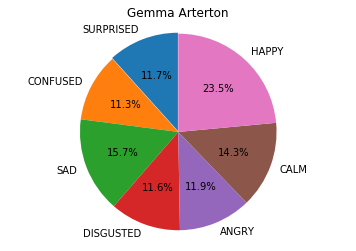

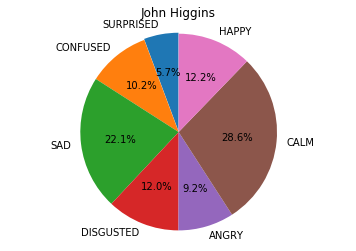

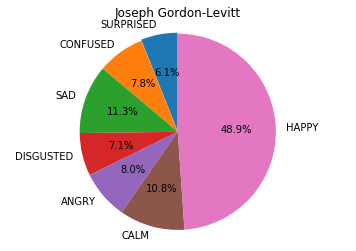

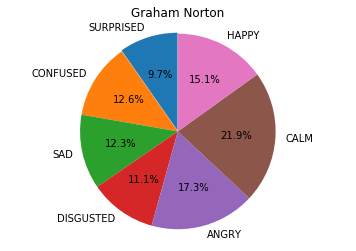

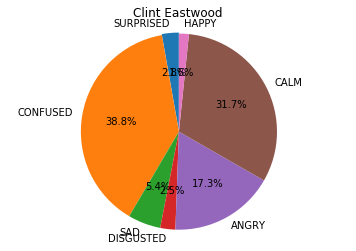

In [22]:
# create a list of celebrities detected and a list of emotions 
name_list,emotion_list = createLists(celebrities_faces_list)                                
#For each celebrity computes the average of each emotion during the video
name_score = genScoreCelebrity(celebrities_faces_list,name_list,emotion_list)
plotPyCharCel(name_score,name_list,emotion_list)

In [ ]:
# just some functions to chec

In [39]:
filename = 'celebrities_emotions.json' 
with open(filename, 'r') as f:
    js_celebrities_faces_list = json.load(f)

In [52]:
js_celebrities_faces_list == celebrities_faces_list

True

In [41]:
filename = 'celebrities_emotions_scores.json' 
with open(filename, 'r') as f:
    js_celebrities_emotions_scores= json.load(f)

In [65]:
import json

def compare_dict(dic1,dic2):
    dump1 = json.dumps(dic1, sort_keys=True)
    dump2 = json.dumps(dic2, sort_keys=True)
    return(dump1 == dump2)

In [67]:
compare_dict(celebrities_faces_list,js_celebrities_faces_list)

True

In [68]:
compare_dict(name_score,js_celebrities_emotions_scores)

True